# Prediction

Create model to predict whether or not a marketing call to a customer would be successful

## Initialise environment and load data

In [1]:
# import libraries
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import unittest
import utils

# run unit tests
_ = unittest.TextTestRunner(verbosity=2).run(unittest.TestLoader().loadTestsFromModule(utils))

from keras import backend
backend.clear_session()

test_categorical (utils.test_corr_fun) ... ok
test_numerical (utils.test_corr_fun) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.014s

OK


In [2]:
# load data
y_train_df, y_valid_df, y_test_df, X_train_df, X_valid_df, X_test_df, ordinality_dict = utils.get_data()

## Exploratory Data Analysis
Plot the distributions of each of the provided feature and assess the relationship to the target

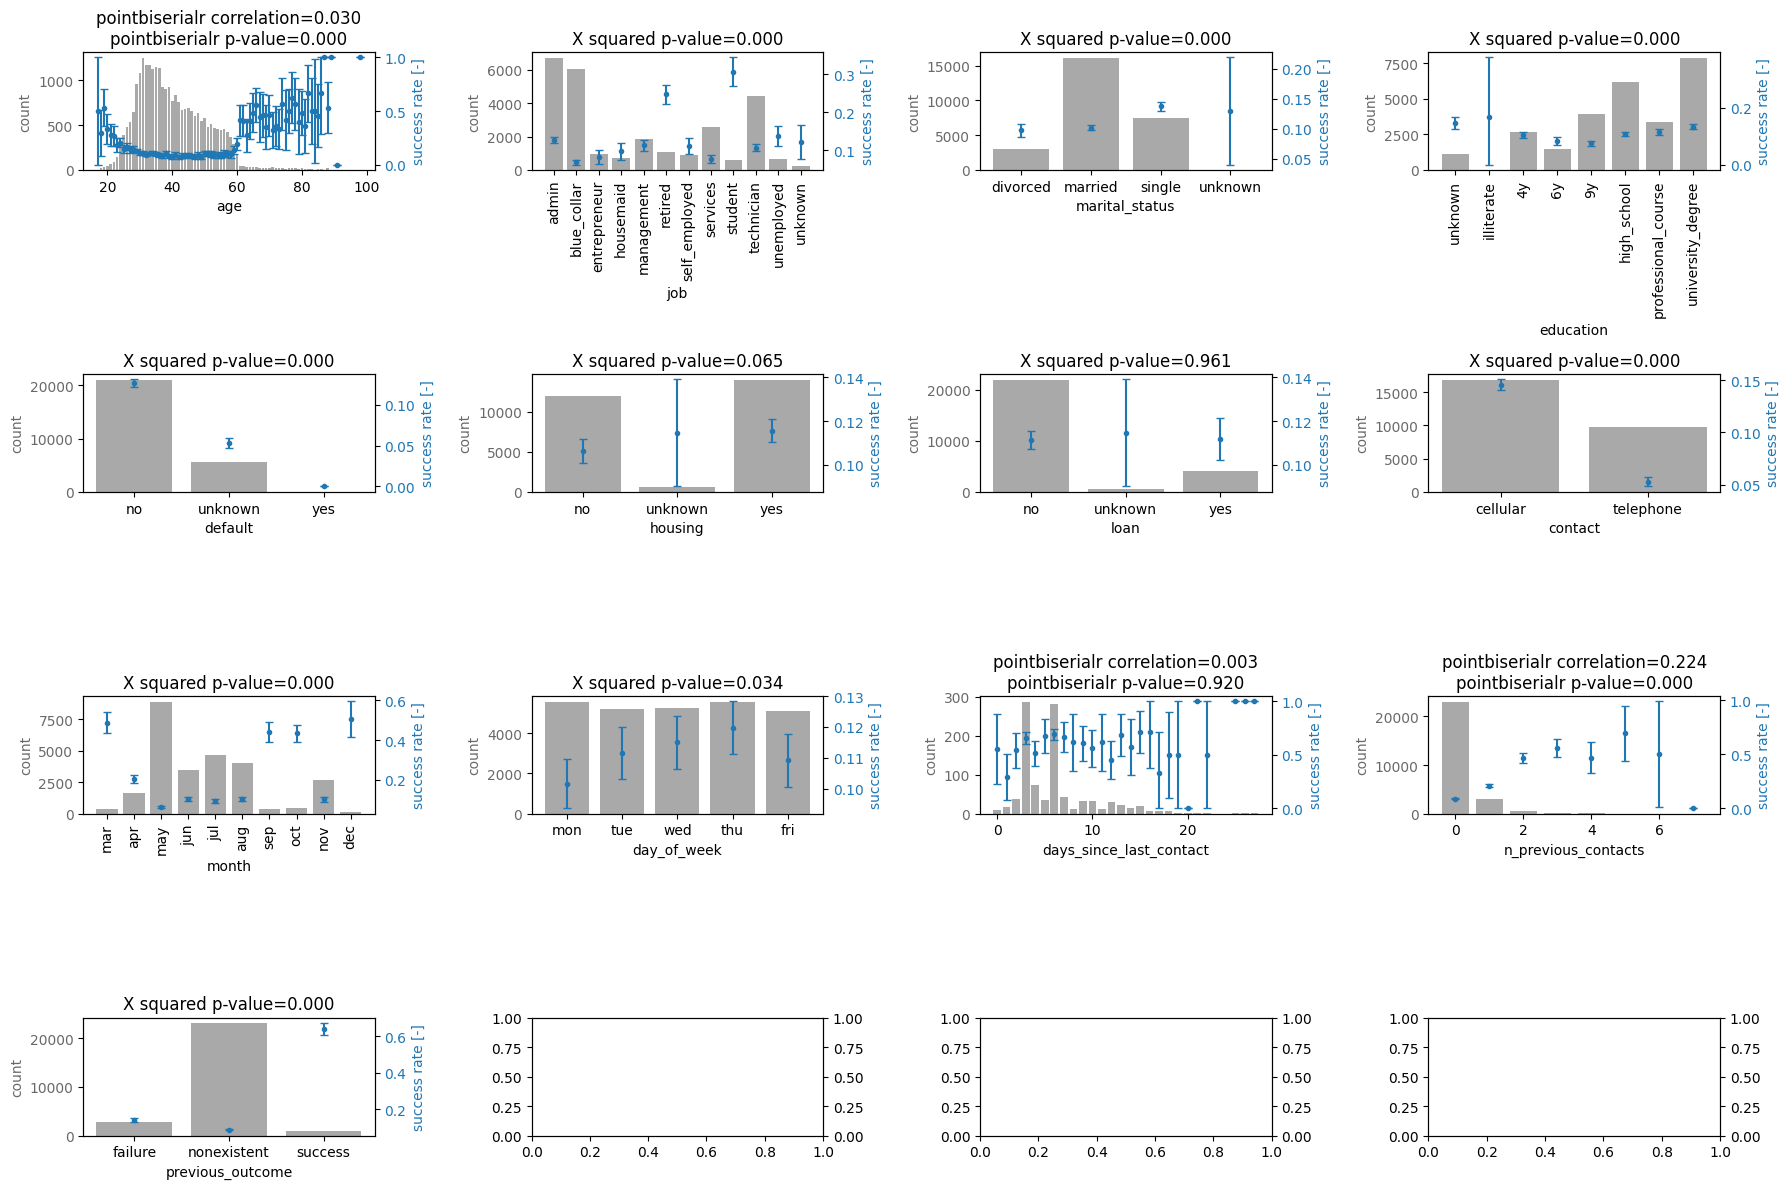

In [3]:
# initalise dataframe of summary statistics
vars_df = pd.DataFrame(columns=['numerical', 'correlation_coefficient', 'p-value'])
vars_df = vars_df.astype({'numerical':'bool', 'correlation_coefficient':'float', 'p-value':'float'})

# initialise plot with two axes (one for current feature and one for target variable to show relationship)
ncols = 4
nrows = int(np.ceil(len(X_train_df.columns)/ncols))
fig, ax1_all = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18,3*nrows))
ax1_all = ax1_all.flatten()
ax2_all = [x.twinx() for x in ax1_all]

# loop through features
for col, ax1, ax2 in zip(X_train_df.columns, ax1_all, ax2_all):

    # extract required column
    col_df = X_train_df[col]

    # apply mask to drop entries from days_since_last_contact (uncontacted user information is captured in n_previous_contacts)
    if col == 'days_since_last_contact':
        mask = col_df!=999
    else:
        mask = [True]*len(col_df)

    # plot distribution/relationship and calculate summary statistics
    vars_df, _, _ = utils.eda_plot(col_df[mask], y_train_df[mask], vars_df, ordinality_dict, ax1, ax2)

fig.tight_layout()

EDA summary:
- `age` exhibits good correlation but current form is U-shaped and symmetric about 40 - reworking the feature to be time from/since 40 to create monotonically increasing feature
- `education` exhibits good correlation but unknown values will need to be imputed due to ordinality
- `housing` exhibit moderate correlation - the p-value does not provide an inclusive include/exclude (greater than 5% but not by much) answer to feature shall be reatined until further evidence is available
- `loan` appears to show no correlation so shall be dropped going forwards
- `month` exhibits good correlation - months with highest success rates are 6 months apart which suggests that feature is not linear
- `day_of_week` exhibits good correlation - day with lowest success rates are at opposite ends of the week which suggests that feature is not linear
- `days_since_last_contact` shows no correlation once the datapoints for uncontacted customers have been removed - this feature shall be dropped going forwards
- `job`, `marital_status`, `default`, `contact`, `n_previous_contacts` and `previous_outcome` are not ordinal and exhibit useful correlation

It is expected that there will likely be lots of multi-colinearity between some combinations of the variables (e.g. `education`-`job`). However, as the main focus of the model is predictive performance, not fully understanding the importance of individual features, this can be tolerated.

## Prepare data
Impute missing values in data and transform to appropriate numerical format for modelling

In [4]:
# initialise and fit preprocessing pipline
preproc_trans = utils.vect_pipe(
    cat_vars = ['job', 'marital_status', 'default', 'housing', 'contact', 'previous_outcome'],
    num_vars = ['n_previous_contacts'],
    ord_vars = dict((k, ordinality_dict[k]) for k in ['month', 'day_of_week']),
    num_sym_vars = {'age': 40},
    ord_mode_vars = dict((k, ordinality_dict[k]) for k in ['education']),
)
preproc_trans.fit(pd.concat([X_train_df, X_valid_df, X_test_df]))

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['job', 'marital_status', 'default', 'housing',
                                  'contact', 'previous_outcome']),
                                ('num', StandardScaler(),
                                 ['n_previous_contacts']),
                                ('ord',
                                 OrdinalEncoder(categories=[['jan', 'feb',
                                                             'mar', 'apr',
                                                             'may', 'jun',
                                                             'jul', 'aug',
                                                             'sep', 'oct',
                                                             'nov', 'dec'],
                                                            ['mon', 'tue',
                                                             'wed', 'thu...
                                 Pipeline(steps=[('pre_vect',
                                                  SymmetricReflector(x_mirror={'age': 40})),
                                                 ('vect', StandardScaler())]),
                                 ['age']),
                                ('ord_mode',
                                 Pipeline(steps=[('pre_vect',
                                                  SimpleImputer(missing_values='unknown',
                                                                strategy='most_frequent')),
                                                 ('vect',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'illiterate',
                                                                              '4y',
                                                                              '6y',
                                                                              '9y',
                                                                              'high_school',
                                                                              'professional_course',
                                                                              'university_degree']]))]),
                                 ['education'])])

In [5]:
# extract feature names
feature_names, column_names = utils.get_feat_names(preproc_trans)
assert all([x==y for x,y in zip(sorted(list(set(column_names))+['loan','days_since_last_contact']), sorted(list(set(X_train_df.columns))))]) # check all columns apart from loan are captured

In [6]:
# transform training data
X_train_arr = preproc_trans.transform(X_train_df)
X_valid_arr = preproc_trans.transform(X_valid_df)
X_test_arr = preproc_trans.transform(X_test_df)

### Define evaluation metrics

Due to the cost of making calls and the potential rewards, each outcome has a different value:

| | | Predicted | |
| ----------- | ----------- | ----------- | ----------- |
| | | Negative | Positive |
| Actual | Negative | 0 GBP | -6 GBP |
| | Positive | 0 GBP | 74 GBP |

The preferred metric considered is the actualised revenue as a proportion of the revenue that could have been achieved if all outcomes were predicted correctly.

_N.B. Unfortunately, sklearn cannot accomodate this custom metric. Therefore, accuracy shall be used for hyperparameter tuning and the aforementioned metric shall be used for comparison._

In [7]:
# define performance metric
score_fun = make_scorer(utils.eval_score)

## Model selection
The selection of the best classifier from a broad selection of well established algorithms follows a 2 step process:
1. For each algorithm, perform a brief hyperparameter tuning (displaying the results of the different hyperparameter values selected) to ensure each algorithm is performing at its best
1. Compare the performance of each algorithm (on both selected evaluation metrics) and select the best performing classifier

#### Naive Bayes

In [8]:
# tune hyperparameters
params_search_nb = {
    'alpha': np.linspace(1.0e-10,1,5,endpoint=True)
}
est_nb = MultinomialNB()
est_search = GridSearchCV(est_nb, params_search_nb, scoring=score_fun, n_jobs=2, cv=2, verbose=1, return_train_score=True)
est_search.fit(X_train_arr-X_train_arr.min(axis=0), y_train_df) # X_train_arr cannot have any negative values
nb_search_df = pd.DataFrame(est_search.cv_results_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


,mean_fit_time,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.003741,0.25,0.249941,0.007188,0.248242,0.006761
1,0.004724,0.0,0.249859,0.007107,0.248269,0.006789
2,0.005876,0.5,0.249832,0.007079,0.248214,0.006843
3,0.004708,0.75,0.249777,0.007079,0.248214,0.006843
4,0.004250,1.0,0.249723,0.007025,0.248187,0.006870


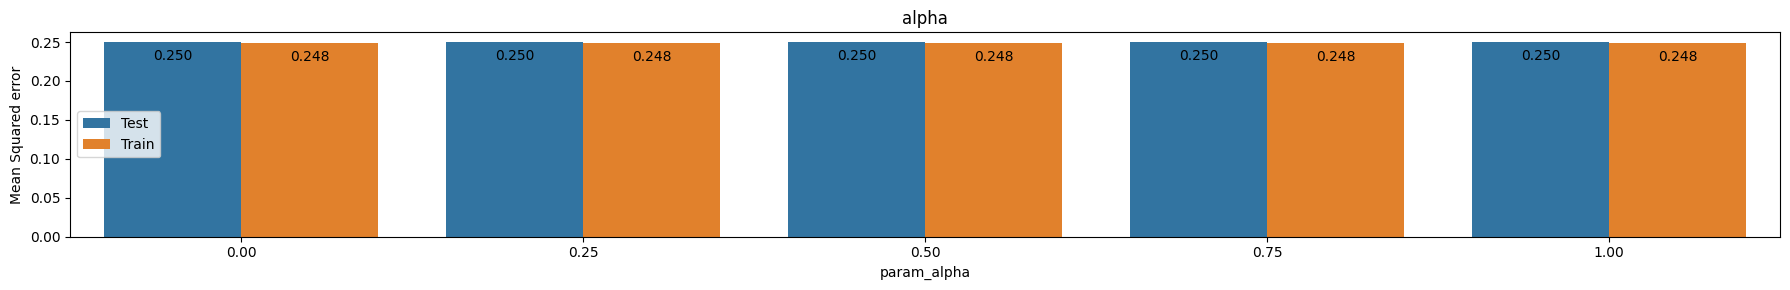

In [9]:
# display results
nb_search_df = utils.drop_columns(nb_search_df)
nb_search_df.sort_values(by=['mean_test_score'], ascending=False, inplace=True, ignore_index=True)
nb_params = nb_search_df.loc[0,'params']
utils.grouped_plot(nb_search_df)
nb_search_df.drop(columns='params').head()

#### Support Vector Machine

In [10]:
# tune hyperparameters
params_search_svm = {
    'C': 2**np.arange(0,11,5)
}
est_svm = LinearSVC(max_iter=1_000)
est_search = GridSearchCV(est_svm, params_search_svm, scoring=score_fun, n_jobs=2, cv=2, verbose=1, return_train_score=True)
est_search.fit(X_train_arr, y_train_df)
svm_search_df = pd.DataFrame(est_search.cv_results_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/skle

,mean_fit_time,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.610210,1,0.180719,0.006652,0.179792,0.005725
1,0.657885,32,0.088651,0.027491,0.089633,0.015022
2,0.657690,1024,0.060425,0.059134,0.066232,0.059670


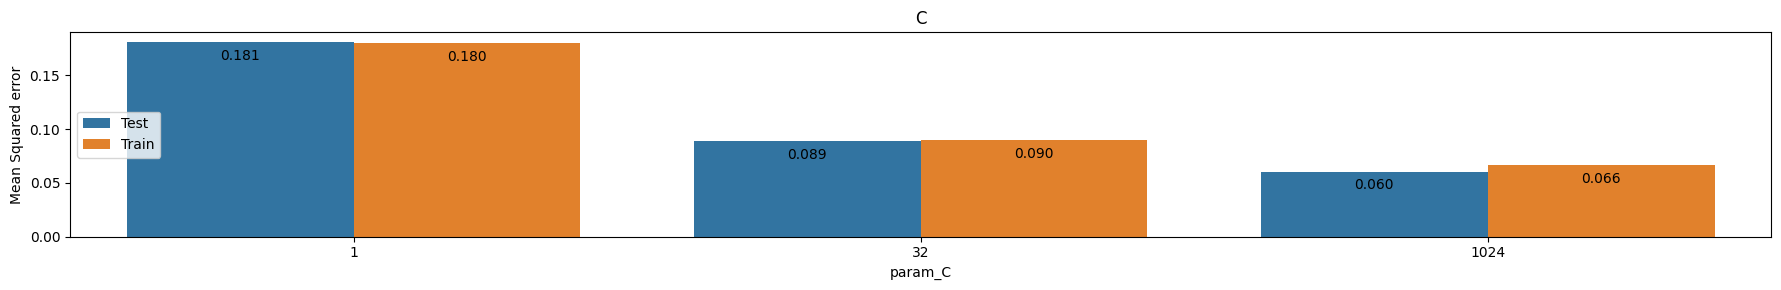

In [11]:
# display results
svm_search_df = utils.drop_columns(svm_search_df)
svm_search_df.sort_values(by=['mean_test_score'], ascending=False, inplace=True, ignore_index=True)
svm_params = svm_search_df.loc[0,'params']
utils.grouped_plot(svm_search_df)
svm_search_df.drop(columns='params').head()

#### Logistic Regression

In [12]:
# tune hyperparameters
params_search_lg = {
    'C': 2**np.arange(0,10,3)
}
est_lg = LogisticRegression(max_iter=1_000, solver='saga', warm_start=True)
est_search = GridSearchCV(est_lg, params_search_lg, scoring=score_fun, n_jobs=2, cv=2, verbose=1, return_train_score=True)
est_search.fit(X_train_arr, y_train_df)
lg_search_df = pd.DataFrame(est_search.cv_results_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,mean_fit_time,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1.729654,8,0.163062,0.009806,0.165806,0.009079
1,1.697343,64,0.163035,0.009833,0.165806,0.009079
2,1.716170,512,0.163035,0.009833,0.165806,0.009079
3,2.025534,1,0.162726,0.009469,0.164852,0.008742


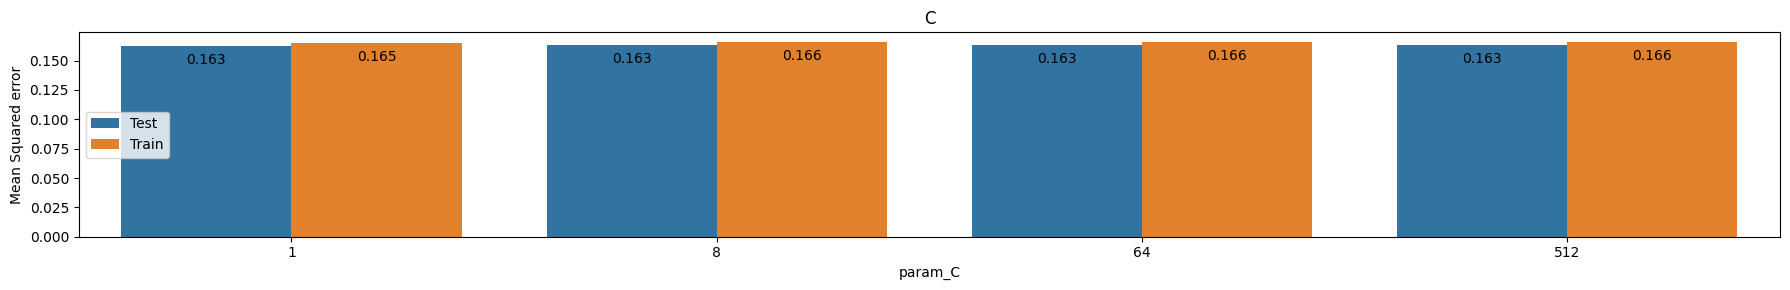

In [13]:
# display results
lg_search_df = utils.drop_columns(lg_search_df)
lg_search_df.sort_values(by=['mean_test_score'], ascending=False, inplace=True, ignore_index=True)
lg_params = lg_search_df.loc[0,'params']
utils.grouped_plot(lg_search_df)
lg_search_df.drop(columns='params').head()

#### Neural network

In [14]:
# instantiate model of selected architecture
def create_neural_network(layer1_units=8, layer2_units=0, activation=None, optimiser='rmsprop'):

    # define network and architecture
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=layer1_units, activation=activation, input_shape=X_train_arr.shape[1:]))
    print(layer2_units, layer2_units>0)
    if layer2_units>0:
        model.add(tf.keras.layers.Dense(units=layer2_units, activation=activation))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # final layer for binary classification
    
    # compile model
    model.compile(
        loss = utils.RevenueAttained(),
        optimizer = optimiser,
        metrics = utils.revenue_attained
    )

    return model

In [17]:
# tune hyperparameters

# fixed parameters
batch_size=256
epochs=100
epochs=10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.01,
    patience=4,
    verbose=0,
    # mode='max',
    restore_best_weights=True
)

# tunable hyperparameters
params_search_nn = {
    'layer1_units': 2**np.arange(1,11,3),
    'layer2_units': [0,2,8],
    'activation': ['sigmoid','relu'],
}

est_nn = KerasClassifier(
    model=create_neural_network,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks = early_stopping,
    layer1_units=None,
    layer2_units=None,
    activation=None,
)

# run tuning
est_search = GridSearchCV(est_nn, params_search_nn, scoring=score_fun, n_jobs=2, cv=2, verbose=0, return_train_score=True)
est_search.fit(X_train_arr, y_train_df)
nn_search_df = pd.DataFrame(est_search.cv_results_)

Metal device set to: Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
Apple M2 Pro
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

0 False
0 False


2024-02-01 10:46:24.580236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:46:24.580251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:46:24.580413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:46:24.580491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

2 True
2 True


2024-02-01 10:46:31.064853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:31.068476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:36.877243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:36.877248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True
8 True


2024-02-01 10:46:37.552059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:37.555842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:43.502213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:43.527685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False
0 False


2024-02-01 10:46:44.209839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:44.230179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:49.363967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:49.364031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True
2 True


2024-02-01 10:46:49.962075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:49.962654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:55.791415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:46:55.829514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:46:57.265665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

8 True


2024-02-01 10:47:01.410942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:47:01.411093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:47:01.550827: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:47:02.055874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:02.842829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

0 False


2024-02-01 10:47:07.677872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:47:07.678040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:47:07.806334: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:47:08.074761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:08.268639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False


2024-02-01 10:47:08.977327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:13.262474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:47:13.993952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:14.106203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:47:14.619429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:20.256264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:47:20.934585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:21.065049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:47:21.647989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:26.884373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False


2024-02-01 10:47:27.453604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:27.527745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:32.216278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

0 False


2024-02-01 10:47:32.568513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:47:32.568717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:47:32.697012: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:47:33.147666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

2 True


2024-02-01 10:47:37.077490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:47:37.077650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:47:37.225666: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:47:37.730056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:37.895996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:47:38.731333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:43.803308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:47:44.701715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:44.744616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:47:45.401972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:50.702955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False


2024-02-01 10:47:51.299454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:51.380327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False


2024-02-01 10:47:51.987485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:56.137186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:47:56.745796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:47:56.796596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:01.327668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

2 True


2024-02-01 10:48:01.909820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:48:01.910028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:48:02.052411: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:48:02.595013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

8 True


2024-02-01 10:48:06.329360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:48:06.329513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:48:06.478421: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:48:06.969088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:08.316896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:48:09.222913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:10.725523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False


2024-02-01 10:48:11.593594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:13.930214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False


2024-02-01 10:48:14.563984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:16.473836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:48:17.095284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:19.400105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:48:19.995048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:22.855179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:48:23.512994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:25.828663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:29.289937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

8 True


2024-02-01 10:48:30.777109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:48:30.777303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:48:30.924445: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:48:31.392008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

0 False


2024-02-01 10:48:34.339081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:48:34.339237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:48:34.466497: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:48:34.919511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:37.142030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False


2024-02-01 10:48:38.000076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:39.834055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:48:40.667802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:42.849178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:48:43.463436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:46.430610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:48:47.103980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:49.218739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:48:49.865053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:52.924702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 False


2024-02-01 10:48:53.572405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:55.636850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:48:58.342580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

0 False


2024-02-01 10:49:00.959209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:49:00.959393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:49:01.080137: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:49:01.524125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

2 True


2024-02-01 10:49:03.426104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:49:03.426274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:49:03.573130: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:49:04.075291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:49:06.250628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2 True


2024-02-01 10:49:07.059536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:49:10.132921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:49:11.037590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:49:13.013270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8 True


2024-02-01 10:49:13.658018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:49:16.919779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:49:19.403457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

0 False


2024-02-01 10:49:19.817160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 10:49:19.817411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-01 10:49:19.998880: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-01 10:49:20.392165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,mean_fit_time,param_activation,param_layer1_units,param_layer2_units,mean_test_score,std_test_score,mean_train_score,std_train_score
0,5.280876,relu,128,0,0.469265,0.005680,0.476272,0.001945
1,6.130354,relu,1024,8,0.466848,0.008224,0.491557,0.000454
2,6.077957,relu,128,2,0.466684,0.005825,0.480907,0.003599
3,5.146793,relu,1024,0,0.466330,0.001345,0.478771,0.003917
4,6.099168,relu,128,8,0.461686,0.010805,0.480579,0.005253


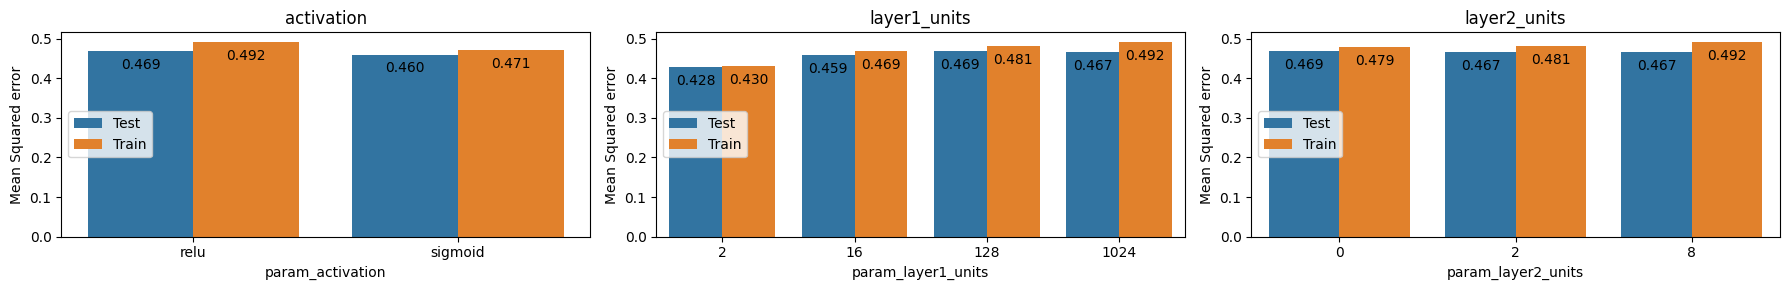

In [18]:
# display results
nn_search_df = utils.drop_columns(nn_search_df)
nn_search_df.sort_values(by=['mean_test_score'], ascending=False, inplace=True, ignore_index=True)
nn_params = nn_search_df.loc[0,'params']
utils.grouped_plot(nn_search_df)
nn_search_df.drop(columns='params').head()

#### Decision tree

In [19]:
# tune hyperparameters
params_search_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': 10**np.arange(1,4),
    'min_samples_split': 2**np.arange(1,11,3),
}
est_dt = DecisionTreeClassifier()
est_search = GridSearchCV(est_dt, params_search_dt, scoring=score_fun, n_jobs=2, cv=2, verbose=1, return_train_score=True)
est_search.fit(X_train_arr, y_train_df)
dt_search_df = pd.DataFrame(est_search.cv_results_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,mean_fit_time,param_criterion,param_max_depth,param_min_samples_split,param_splitter,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.052571,gini,1000,2,best,0.233238,0.004371,0.888120,0.004626
1,0.052565,gini,100,2,best,0.226704,0.009524,0.888120,0.004626
2,0.050151,gini,1000,16,best,0.220069,0.005544,0.413048,0.014949
3,0.034294,entropy,1000,2,random,0.218843,0.005044,0.888120,0.004626
4,0.050190,gini,100,16,best,0.217325,0.004253,0.413303,0.016603


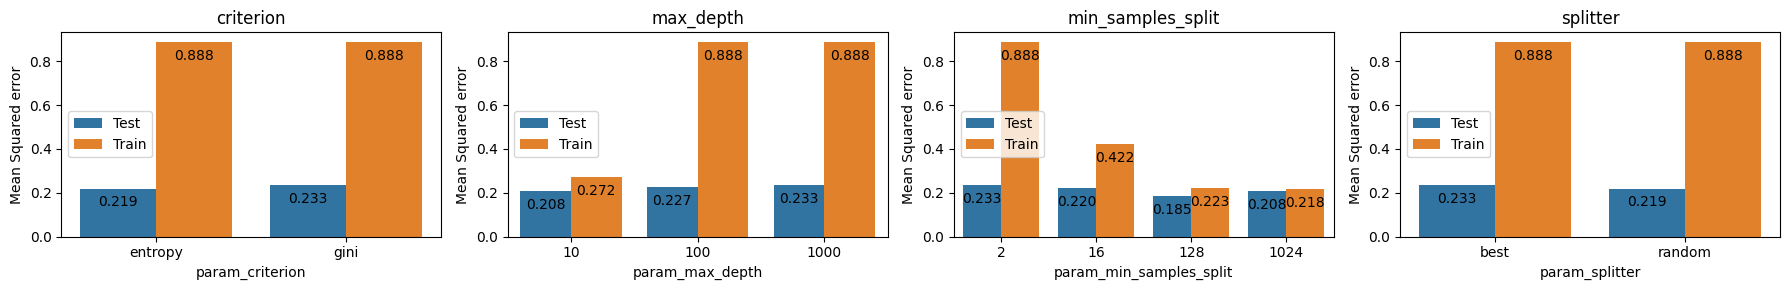

In [20]:
# display results
dt_search_df = utils.drop_columns(dt_search_df)
dt_search_df.sort_values(by=['mean_test_score'], ascending=False, inplace=True, ignore_index=True)
dt_params = dt_search_df.loc[0,'params']
utils.grouped_plot(dt_search_df)
dt_search_df.drop(columns='params').head()

#### Random forest

In [21]:
# tune hyperparameters
params_search_rf = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': ((10**0.5)**np.arange(1,6,4)).astype(int),
    'max_samples': (10.0**np.arange(-2,0)).tolist()+[None]
}
est_rf = RandomForestClassifier()
est_search = GridSearchCV(est_rf, params_search_rf, scoring=score_fun, cv=2, verbose=1, return_train_score=True)
est_search.fit(X_train_arr, y_train_df)
rf_search_df = pd.DataFrame(est_search.cv_results_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


,mean_fit_time,param_criterion,param_max_samples,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.026152,entropy,None,3,0.198422,0.007834,0.750223,0.005080
1,0.008735,entropy,0.1,3,0.195096,0.025773,0.263791,0.033252
2,0.025002,gini,None,3,0.193815,0.003899,0.738763,0.009324
3,2.432150,gini,None,316,0.190316,0.008652,0.894918,0.005862
4,2.519888,entropy,None,316,0.189889,0.005026,0.893373,0.003699


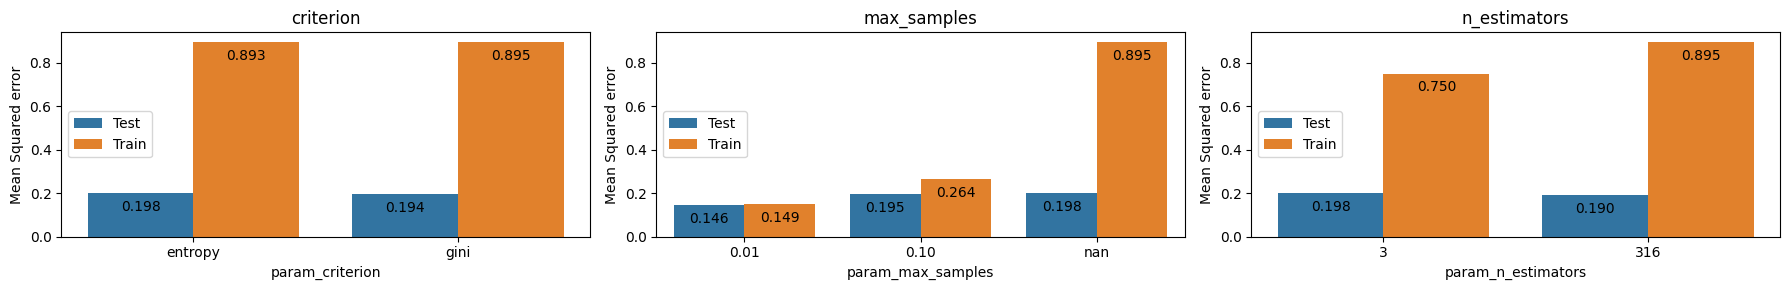

In [22]:
# display results
rf_search_df = utils.drop_columns(rf_search_df)
rf_search_df.sort_values(by=['mean_test_score'], ascending=False, inplace=True, ignore_index=True)
rf_params = rf_search_df.loc[0,'params']
utils.grouped_plot(rf_search_df)
rf_search_df.drop(columns='params').head()

#### Gradient Boosting

In [23]:
# tune hyperparameters
params_search_gb = {
    'n_estimators': (10**np.arange(1,3)).astype(int),
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': (10**np.arange(1,3)).astype(int)
    }
est_gb = GradientBoostingClassifier(init=LogisticRegression(max_iter=1_000, solver='saga', **lg_params))
est_search = GridSearchCV(est_gb, params_search_gb, scoring=score_fun, n_jobs=2, cv=2, verbose=1, return_train_score=True)
est_search.fit(X_train_arr, y_train_df)
gb_search_df = pd.DataFrame(est_search.cv_results_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/RDIB/Documents/GitHub/ML-projects/Marketing optimisation/env/lib/pyth

,mean_fit_time,param_criterion,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
0,25.511789,squared_error,100,100,0.220660,0.002408,0.889047,0.003699
1,25.708157,friedman_mse,100,100,0.220297,0.004571,0.889047,0.003699
2,5.500136,squared_error,10,100,0.213099,0.006698,0.721124,0.023619
3,5.469628,friedman_mse,10,100,0.211618,0.007234,0.721124,0.023619
4,4.160870,friedman_mse,100,10,0.209873,0.006198,0.884531,0.001763


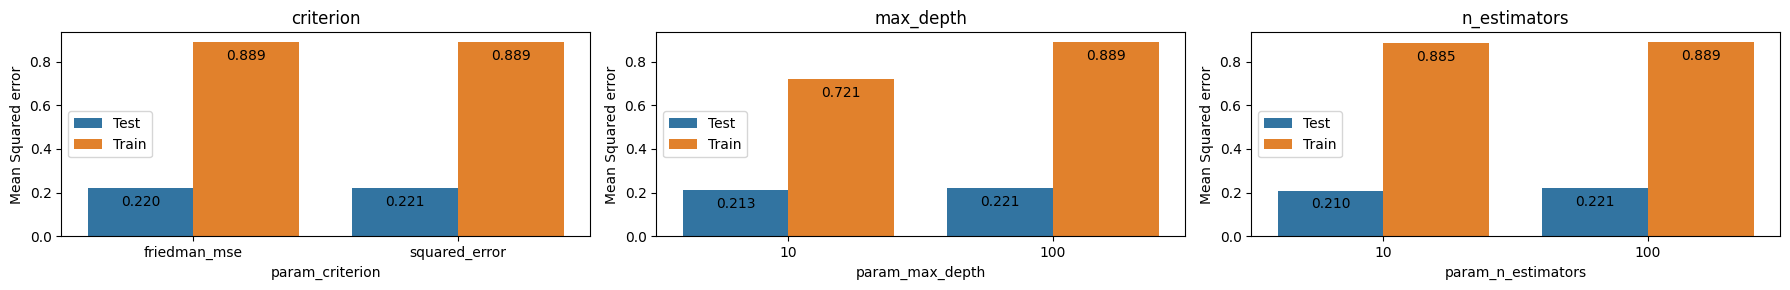

In [24]:
# display results
gb_search_df = utils.drop_columns(gb_search_df)
gb_search_df.sort_values(by=['mean_test_score'], ascending=False, inplace=True, ignore_index=True)
gb_params = gb_search_df.loc[0,'params']
utils.grouped_plot(gb_search_df)
gb_search_df.drop(columns='params').head()

#### Compare results of different techniques

In [25]:
# collate estimators
est_list = [
    MultinomialNB(**nb_params),
    LinearSVC(max_iter=100_000, **svm_params),
    LogisticRegression(max_iter=10_000, solver='saga', **lg_params),
    KerasClassifier(
        model=create_neural_network,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        callbacks = early_stopping,
        **nn_params,
    ),
    DecisionTreeClassifier(**dt_params),
    RandomForestClassifier(**rf_params),
    GradientBoostingClassifier(init=LogisticRegression(max_iter=10_000, solver='saga', **lg_params),**gb_params),
]

In [26]:
# evaluate each model on most appt evaluation function
for est_solo in est_list:

    # train model
    name = est_solo.__class__.__name__
    X_train_arr_in = X_train_arr-X_train_arr.min(axis=0) if name=='MultinomialNB' else X_train_arr # shift inputs away from negatives for the naive bayes model
    est_solo.fit(X_train_arr_in, y_train_df)

    # evaluate classifier
    X_valid_arr_in = X_valid_arr-X_valid_arr.min(axis=0) if name=='MultinomialNB' else X_valid_arr # shift inputs away from negatives for the naive bayes model
    y_pred = pd.Series(est_solo.predict(X_valid_arr_in), name='predict')
    y_act = pd.Series(y_valid_df.values, name='actual')
    score = utils.eval_score(y_act, y_pred)

    # display performance values
    print(f'{name}: {(100*score):.2f}% possible revenue predicted')

MultinomialNB: 24.95% possible revenue predicted
LinearSVC: 18.66% possible revenue predicted
LogisticRegression: 17.11% possible revenue predicted
0 False


2024-02-01 10:52:43.934666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-02-01 10:52:52.887314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KerasClassifier: 51.90% possible revenue predicted
DecisionTreeClassifier: 22.95% possible revenue predicted
RandomForestClassifier: 19.17% possible revenue predicted
GradientBoostingClassifier: 20.30% possible revenue predicted


The Neural Network model is to be selected as it exhibits the best ability to yield the most revenue. However, it should be noted that this model was the only one that was trained using the custom metric as it's loss function and it is therefore not surprising that it performed best. It would be interesting to see how other approaches would perfform if they were adapted to be trained on the custom metric.

## Create and evaluate final model
Train selected model on entire training set and evaluate performance on test set

In [27]:
# train selected model on full training set
est = KerasClassifier(
    model = create_neural_network,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 0,
    callbacks = early_stopping,
    **nn_params,
).fit(X_train_arr, y_train_df)

0 False


2024-02-01 10:53:54.026249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [28]:
# evaluate on training set
y_pred = pd.Series(est.predict(X_train_arr), name='predict')
y_act = pd.Series(y_train_df.values, name='actual')
print(f'{(100*utils.eval_score(y_act, y_pred)):.2f}%')
labels=[False, True]
pd.DataFrame(confusion_matrix(y_act, y_pred, labels=labels), index=labels, columns=labels)

2024-02-01 10:54:02.999886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48.32%


,False,True
False,10668,13047
True,479,2495


In [29]:
# evaluate on valid set
y_pred = pd.Series(est.predict(X_valid_arr), name='predict')
y_act = pd.Series(y_valid_df.values, name='actual')
print(f'{(100*utils.eval_score(y_act, y_pred)):.2f}%')
labels=[False, True]
pd.DataFrame(confusion_matrix(y_act, y_pred, labels=labels), index=labels, columns=labels)

51.91%


,False,True
False,1147,1464
True,52,303


In [30]:
# evaluate on testing set
y_pred = pd.Series(est.predict(X_test_arr), name='predict')
y_act = pd.Series(y_test_df.values, name='actual')
print(f'{(100*utils.eval_score(y_act, y_pred)):.2f}%')
labels=[False, True]
pd.DataFrame(confusion_matrix(y_act, y_pred, labels=labels), index=labels, columns=labels)

51.28%


,False,True
False,1326,1586
True,58,325


The slightly better performance on the test set is suspicious; normally test performance is slightly lower than training performance if no over fitting is present. This may be systematic due to the method with which the train-test split was made. If weak patterns were observed in the training time period but these relationships were stronger in the test period, this would explain this observation. A prefereable alternative would be to perform the split across randomised devices that span the full time period.

## Feature importance

Evaluate which features of the model are the most important

_N.B. Expect this analysis to be flawed due to the potential presence of multi-colinearity_

In [31]:
# calculate feature importance using permutation importance - alternative scoring function used due to sklearn limitations
feat_imp_df = pd.DataFrame(
    {
        'importance': permutation_importance(
                est,
                X_test_arr,
                y_test_df,
                scoring=score_fun,
                n_repeats=10
        )['importances_mean']
    },
    index=feature_names
)
feat_imp_df['feature'] = column_names
feat_imp_df['importance'] = feat_imp_df['importance']*100

/var/folders/cf/l2k6zjsj3n5g2wgcr4xyq3880000gp/T/ipykernel_5148/2963633816.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([i.get_text().replace('_',' ').title() for i in ax.get_yticklabels()])


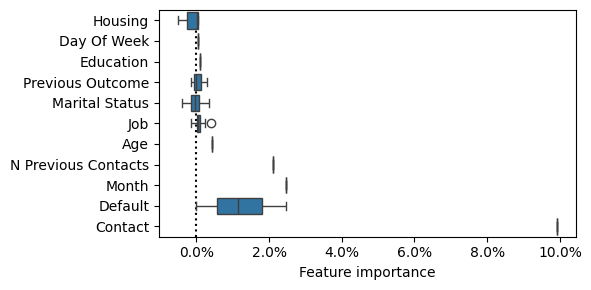

In [32]:
# display feature importances

# group by feature
feat_imp_mean_df = feat_imp_df.groupby('feature').agg(['mean','max','count']).sort_values(by=('importance','max'))
feat_imp_mean_df.columns = feat_imp_mean_df.columns.droplevel(0)

# plot as boxplot
fig, ax = plt.subplots(figsize=(6,3))
ax.axvline(color='k', linestyle=':', linewidth=1.5)
sns.boxplot(
    x='importance',
    y='feature',
    data=feat_imp_df,
    order=feat_imp_mean_df.index,
    ax=ax
)

# annotate plot
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_yticklabels([i.get_text().replace('_',' ').title() for i in ax.get_yticklabels()])
ax.set_xlabel('Feature importance')
ax.set_ylabel('')
fig.tight_layout()

The permutation importance values are all relatively low. This is probably due to the difficulty with which accuracy can be altered due to the class imbalance. If the analysis was able to be repeated using the custom scoring function, the feature importances would likely be larger.

This method of calculating feature importance is quick and useful for feature selection. Alternatively, SHAP could provide more information that better incorporates the interaction between features. However, the choice would depend on the intended use case.

### Save for reuse
Combine fitted preprocessing pipeline and estimator and save for reuse

In [33]:
# save keras model and transformer
est.model_.save('estimator.h5')
joblib.dump(preproc_trans, 'transformer.pkl')

['transformer.pkl']

## Summary
The data has been explored and the knowledge gained has been used to engineer the features (e.g. the reflection of `age` to create a monotonically increasing relationship to the target) and select features to be dropped (e.g. `loan` had no significant relationship to the target). A preprocessing pipeline was created to impute and vectorise the resulting dataset in preparation for modelling. A broad range of classifier algorithms were tuned and compared. Naive Bayes was selected as the best performing classifier but it was noted that a Neural Network trained on the final custom scorer would potentially outperform Naive Bayes if there was time to investigate thoroughly. The resulting model was able to yield ~50% of the potential revenue with a slight increase from the training to test sets. The better performance on the test set is abnormal and may be indicative that there is a systematic difference between the train and test datasets.